### Libs import

#### Primary libs

In [1]:
from tqdm.notebook import tqdm

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import optuna

import warnings
warnings.filterwarnings("ignore")

#### ML modules

Torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Not Torch

In [4]:
import gc

from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Custom modules

In [5]:
from modules.loss_functions import  SharpeLoss, MeanReturnLoss, AltMeanReturnLoss, \
                                    DynamicPortfolioLoss
from modules.networks import  LSTMModel, LSTMWithAttention, LSTMWithAttentionAlt, ConvLSTMWithAttention, \
                              AttentionMLP

### Functions definings

### Dataloading

In [6]:
PATH = 'data/binance/fut/hour'

close = pd.read_csv(f'{PATH}/close.csv', index_col='openTime')
open = pd.read_csv(f'{PATH}/open.csv', index_col='openTime')
high = pd.read_csv(f'{PATH}/high.csv', index_col='openTime')
low = pd.read_csv(f'{PATH}/low.csv', index_col='openTime')
qvolume = pd.read_csv(f'{PATH}/qvolume.csv', index_col='openTime')
bvolume = pd.read_csv(f'{PATH}/bvolume.csv', index_col='openTime')
ntrades = pd.read_csv(f'{PATH}/ntrades.csv', index_col='openTime')
takerbuybvolume = pd.read_csv(f'{PATH}/takerbuybvolume.csv', index_col='openTime')
takerbuyqvolume = pd.read_csv(f'{PATH}/takerbuyqvolume.csv', index_col='openTime')

In [7]:
good_tickers = close.isna().sum()[close.isna().sum() < 10_000].index

close = close[good_tickers] 
close.index = pd.to_datetime(close.index)
close = close.resample('4H').last()

open = open[good_tickers]
open.index = pd.to_datetime(open.index)
open = open.resample('4H').first()

high = high[good_tickers]
high.index = pd.to_datetime(high.index)
high = high.resample('4H').max()

low = low[good_tickers]
low.index = pd.to_datetime(low.index)
low = low.resample('4H').min()

bvolume = bvolume[good_tickers]
bvolume.index = pd.to_datetime(bvolume.index)
bvolume = bvolume.resample('4H').sum()

qvolume = qvolume[good_tickers]
qvolume.index = pd.to_datetime(qvolume.index)
qvolume = qvolume.resample('4H').sum()

ntrades = ntrades[good_tickers]
ntrades.index = pd.to_datetime(ntrades.index)
ntrades = ntrades.resample('4H').sum()

takerbuybvolume = takerbuybvolume[good_tickers]
takerbuybvolume.index = pd.to_datetime(takerbuybvolume.index)
takerbuybvolume = takerbuybvolume.resample('4H').sum()

takerbuyqvolume = takerbuyqvolume[good_tickers]
takerbuyqvolume.index = pd.to_datetime(takerbuyqvolume.index)
takerbuyqvolume = takerbuyqvolume.resample('4H').sum()



returns = close.pct_change().shift(-1).dropna()
ret_col = np.array(returns.columns) + '_ret'
returns.columns = ret_col

close_col = np.array(close.columns) + '_close'
close.columns = close_col

open_col = np.array(open.columns) + '_open'
open.columns = open_col

high_col = np.array(high.columns) + '_high'
high.columns = high_col

low_col = np.array(low.columns) + '_low'
low.columns = low_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

qvolume_col = np.array(qvolume.columns) + '_qvolume'
qvolume.columns = qvolume_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

ntrades_col = np.array(ntrades.columns) + '_ntrades'
ntrades.columns = ntrades_col

takerbuybvolume_col = np.array(takerbuybvolume.columns) + '_takerbuybvolume'
takerbuybvolume.columns = takerbuybvolume_col

takerbuyqvolume_col = np.array(takerbuyqvolume.columns) + '_takerbuyqvolume'
takerbuyqvolume.columns = takerbuyqvolume_col


train_columns = np.array([close_col, open_col, high_col, low_col, bvolume_col, qvolume_col, ntrades_col, takerbuybvolume_col, takerbuyqvolume_col])
train_columns = train_columns.reshape(train_columns.shape[0] * train_columns.shape[1],)


full_data = pd.concat([
  close.pct_change(), open.pct_change(), high.pct_change(), low.pct_change(), bvolume.pct_change(),
  qvolume.pct_change(), ntrades.pct_change(), takerbuybvolume.pct_change(), takerbuyqvolume.pct_change(), returns
], axis=1).dropna()
full_data.index = pd.to_datetime(full_data.index) # Не только pct_change (close - оставляем, open, high, low / close, volume - выбрать один и поделить на него)

training_data = full_data[train_columns]



window_size = 100

all_x = np.lib.stride_tricks.sliding_window_view(training_data.values, (window_size, training_data.shape[1]))[:, 0]
all_y = full_data[ret_col].iloc[99:].values

In [8]:
# Формируем обучающую выборку
x_test = all_x[-850:].view()  # Все, кроме последних 1000
y_test = all_y[-850:].view()  # Все, кроме последних 1000

x = all_x[:-(850 + 120)].view()
y = all_y[:-(850 + 120)].view()

# Определяем длину валидационной выборки
val_len = 1000

# Определяем индексы для валидационной выборки
val_start = x.shape[0] // 2 - val_len // 2
val_end = val_start + val_len

# Формируем валидационную выборку
x_val = x[val_start:val_end]
y_val = y[val_start:val_end]

# Определяем отступы для тестовой выборки
offset = 110

# Индексы для тестовой выборки
test_start = max(0, val_start - offset)
test_end = min(x.shape[0], val_end + offset)

# Формируем тренировочную выборку
x_train = np.concatenate((x[:test_start], x[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

# Проверяем размеры выборок
print(f"train_x shape: {x_train.shape}")
print(f"train_y shape: {y_train.shape}")
print(f"val_x shape: {x_val.shape}")
print(f"val_y shape: {y_val.shape}")
print(f"test_x shape: {x_test.shape}")
print(f"test_y shape: {y_test.shape}")

train_x shape: (5262, 100, 567)
train_y shape: (5262, 63)
val_x shape: (1000, 100, 567)
val_y shape: (1000, 63)
test_x shape: (850, 100, 567)
test_y shape: (850, 63)


In [9]:
x_train = torch.Tensor(x_train)
x_train = np.where(np.isinf(x_train), np.nan, x_train)
x_train = np.where(np.isnan(x_train), np.nanmean(x_train, axis=0), x_train)
x_train = torch.Tensor(x_train)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = np.where(np.isinf(y_train), np.nan, y_train)
y_train = np.where(np.isnan(y_train), np.nanmean(y_train, axis=0), y_train)
y_train = torch.Tensor(y_train)


x_val = torch.Tensor(x_val)
x_val = np.where(np.isinf(x_val), np.nan, x_val)
x_val = np.where(np.isnan(x_val), np.nanmean(x_val, axis=0), x_val)
x_val = torch.Tensor(x_val)

y_val = torch.tensor(y_val, dtype=torch.float32)
y_val = np.where(np.isinf(y_val), np.nan, y_val)
y_val = np.where(np.isnan(y_val), np.nanmean(y_val, axis=0), y_val)
y_val = torch.Tensor(y_val)

x_test = torch.Tensor(x_test)
x_test = np.where(np.isinf(x_test), np.nan, x_test)
x_test = np.where(np.isnan(x_test), np.nanmean(x_test, axis=0), x_test)
x_test = torch.Tensor(x_test)

y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = np.where(np.isinf(y_test), np.nan, y_test)
y_test = np.where(np.isnan(y_test), np.nanmean(y_test, axis=0), y_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_val.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_test.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

Shape of x_train: torch.Size([5262, 100, 567])
Shape of y_train: torch.Size([5262, 63])
Shape of x_train: torch.Size([1000, 100, 567])
Shape of y_train: torch.Size([850, 63])
Shape of x_train: torch.Size([850, 100, 567])
Shape of y_train: torch.Size([850, 63])


### ML

In [17]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 450  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
share_values = []
weights_penalties = []
turnover_penalties = []

In [19]:
sharpe_loss = SharpeLoss(turnover_penalty_weight=10)
returns_loss = DynamicPortfolioLoss(turnover_weight=1.5, min_turnover=0)

In [23]:
# Параметры модели и гиперпараметры
PARAMS_DICT = {
    'input_size': x_train.shape[2],           # Количество факторов
    'hidden_size': 21,                        # Уменьшение hidden_size для снижения сложности модели
    'hidden_size2': 21,                       # Согласованный размер для второго слоя LSTM
    'output_size': y_train.shape[1],          # Количество выходов
    'learning_rate': 0.0001,                 # Уменьшение learning rate для более плавного обучения
    'dropout1': 0.1,                          # Увеличение dropout для LSTM слоев
    'dropout2': 0.1,                          # Увеличение dropout для выхода
    'num_epochs': 100,                        # Оставляем 100 эпох, но добавим раннюю остановку
    'num_heads': 3,                           # Уменьшение числа голов в attention слое
    'conv_out_channels': 64,                  # Уменьшение числа каналов в сверточном слое для снижения сложности модели
    'conv_kernel_size': 3,                    # Размер ядра свертки остается прежним
    'PRINT_PARAM': 1,                         # Печать каждые 5 эпох для мониторинга
    'device': device,
    'batch_size': 32,                         # Уменьшение batch_size для улучшения обобщающей способности
    'alpha': sharpe_loss.alpha,               # Параметры функции потерь остаются
    'epsilon': sharpe_loss.epsilon,
    'weight_penalty_factor': sharpe_loss.weight_penalty_factor,
    'optimizer': 'AdamW',                     # Используем AdamW для улучшенной регуляризации
    'weight_decay': 8e-4,                     # Увеличение weight_decay для более сильной регуляризации
    'scheduler_step_size': 10,                # Понижаем learning rate каждые 10 эпох
    'scheduler_gamma': 0.5,                   # Больше снижаем learning rate при scheduler step для стабилизации обучения
    'early_stopping_threshold': 0.005         # Порог для ранней остановки на валидационной метрике
}

pred_dict = {}
pred_dict['train'] = []
pred_dict['val'] = []
pred_dict['test'] = []

# Гиперпараметры
input_size = PARAMS_DICT['input_size']  # Количество факторов (465)
hidden_size = PARAMS_DICT['hidden_size']  # Размер скрытого слоя
hidden_size2 = PARAMS_DICT['hidden_size2'] #
output_size = PARAMS_DICT['output_size']   # Одно выходное значение
learning_rate = PARAMS_DICT['learning_rate']
num_epochs = PARAMS_DICT['num_epochs']
PRINT_PARAM = PARAMS_DICT['PRINT_PARAM']

# Инициализация модели, потерь и оптимизатора
model = AttentionMLP(
    input_size=input_size,
    hidden_size=171,
    output_size=output_size,
    num_heads=9,
    dropout=0.5
).to(device)
# model = ConvLSTMWithAttention(
#     input_size,
#     hidden_size,
#     hidden_size2,
#     output_size,
#     dropout=PARAMS_DICT['dropout1'],
#     dropout2=PARAMS_DICT['dropout2'],
#     num_heads=PARAMS_DICT['num_heads'],
#     conv_out_channels=PARAMS_DICT['conv_out_channels']
# ).to(device)
criterion = returns_loss.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=PARAMS_DICT['weight_decay'])
scheduler = StepLR(optimizer, step_size=PARAMS_DICT['scheduler_step_size'], gamma=PARAMS_DICT['scheduler_gamma'])

train_losses = []
val_losses = []
train_sharpe_ratios = []
train_volatility_values = []

val_sharpe_ratios = []
train_turnovers = []
val_turnovers = []
val_volatility_values = []

# Early stopping threshold для Val Margin returns
early_stopping_threshold = 0.01
best_val_sharpe = float('-inf')  # Инициализируем худшим возможным значением

# Параметры EMA
ema_alpha = 0.1  # Коэффициент сглаживания для EMA
ema_val_sharpe = 0
ema_val_turnover = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    epoch_sharpe = 0
    epoch_turnover = 0
    epoch_volatility = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход (forward pass)
        outputs = model(batch_x)

        # Вычисление потерь
        loss, sharpe_ratio, turnover = criterion(outputs.squeeze(), batch_y.float())

        # Обратный проход (backward pass) для вычисления градиентов
        loss.backward()

        # Обновление весов
        optimizer.step()

        # Агрегация потерь за эпоху
        epoch_loss += loss.item()
        epoch_sharpe += sharpe_ratio
        epoch_turnover += turnover
        # epoch_volatility += tvolatility

    epoch_loss /= len(train_loader)
    epoch_sharpe /= len(train_loader)
    epoch_turnover /= len(train_loader)
    epoch_volatility /= len(train_loader)

    train_losses.append(epoch_loss)
    train_sharpe_ratios.append(epoch_sharpe)
    train_turnovers.append(epoch_turnover)
    train_volatility_values.append(epoch_volatility)

    # Валидация модели
    model.eval()
    val_loss = 0
    val_sharpe = 0
    val_turnover = 0
    val_volatility = 0

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            loss, sharpe_ratio, turnover = criterion(val_outputs.squeeze(), val_y.float())

            val_loss += loss.item()
            val_sharpe += sharpe_ratio
            val_turnover += turnover
            # val_volatility += vvolatility

    val_loss /= len(val_loader)
    val_sharpe /= len(val_loader)
    val_turnover /= len(val_loader)
    val_volatility /= len(val_loader)

    val_losses.append(val_loss)
    val_sharpe_ratios.append(val_sharpe)
    val_turnovers.append(val_turnover)
    val_volatility_values.append(val_volatility)

    # # Экспоненциальное сглаживание для метрик
    # ema_val_sharpe = ema_alpha * val_sharpe + (1 - ema_alpha) * ema_val_sharpe
    # ema_val_turnover = ema_alpha * val_turnover + (1 - ema_alpha) * ema_val_turnover

    # Обновление learning rate через scheduler
    scheduler.step()

    # Адаптивное снижение weight decay на поздних эпохах
    if epoch == 50:
        for param_group in optimizer.param_groups:
            param_group['weight_decay'] *= 0.5

    # Печать результатов
    if epoch % PRINT_PARAM == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.10f}, Validation Loss: {val_loss:.10f}')
        print(f'Train Margin returns: {epoch_sharpe:.10f}, Val Margin returns: {val_sharpe:.10f}')
        print(f'Train Turnover Penalty: {epoch_turnover:.10f}, Val Turnover Penalty: {val_turnover:.10f}')
        # print(f"EMA Val Sharpe: {ema_val_sharpe:.10f}, EMA Val Turnover: {ema_val_turnover:.10f}")
        # print('train_volatility:', tvolatility, 'val_volatility:', vvolatility)
        print()

    # Early stopping на основе двух метрик (val_sharpe и val_turnover)
    # if val_sharpe > best_val_sharpe and val_turnover < early_stopping_threshold:
    #     best_val_sharpe = val_sharpe  # Обновляем лучшее значение
    #     print(f"Early stopping at epoch {epoch} based on Sharpe Ratio and turnover threshold.")
    #     break

# Визуализация потерь и компонентов функции потерь
plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_losses) + 1, PRINT_PARAM), train_losses, label='Train Loss')
plt.scatter(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_sharpe_ratios) + 1, PRINT_PARAM), train_sharpe_ratios, label='Train Margin returns')
plt.scatter(range(PRINT_PARAM, len(val_sharpe_ratios) + 1, PRINT_PARAM), val_sharpe_ratios, label='Validation Margin returns', color='r')
plt.xlabel('Epoch')
plt.ylabel('Margin returns')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_turnovers) + 1, PRINT_PARAM), train_turnovers, label='Train Turnover')
plt.scatter(range(PRINT_PARAM, len(val_turnovers) + 1, PRINT_PARAM), val_turnovers, label='Validation Turnover', color='r')
plt.xlabel('Epoch')
plt.ylabel('Turnover')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100], Loss: -0.0042739744, Validation Loss: 0.0008156192
Train Margin returns: 0.0001188993, Val Margin returns: -0.0001295836
Train Turnover Penalty: 0.0008176295, Val Turnover Penalty: 0.0294271714

Epoch [1/100], Loss: -0.0079186475, Validation Loss: 0.0007757324
Train Margin returns: 0.0002245486, Val Margin returns: -0.0001380579
Train Turnover Penalty: 0.0008387067, Val Turnover Penalty: 0.0360234696

Epoch [2/100], Loss: -0.0084030953, Validation Loss: 0.0007586883
Train Margin returns: 0.0002355449, Val Margin returns: -0.0001385176
Train Turnover Penalty: 0.0008213650, Val Turnover Penalty: 0.0405369066

Epoch [3/100], Loss: -0.0143548803, Validation Loss: 0.0008759873
Train Margin returns: 0.0004009281, Val Margin returns: -0.0001461119
Train Turnover Penalty: 0.0008202172, Val Turnover Penalty: 0.0380687236

Epoch [4/100], Loss: -0.0169799695, Validation Loss: 0.0010374777
Train Margin returns: 0.0004735464, Val Margin returns: -0.0001558209
Train Turnover Penalty: 

KeyboardInterrupt: 

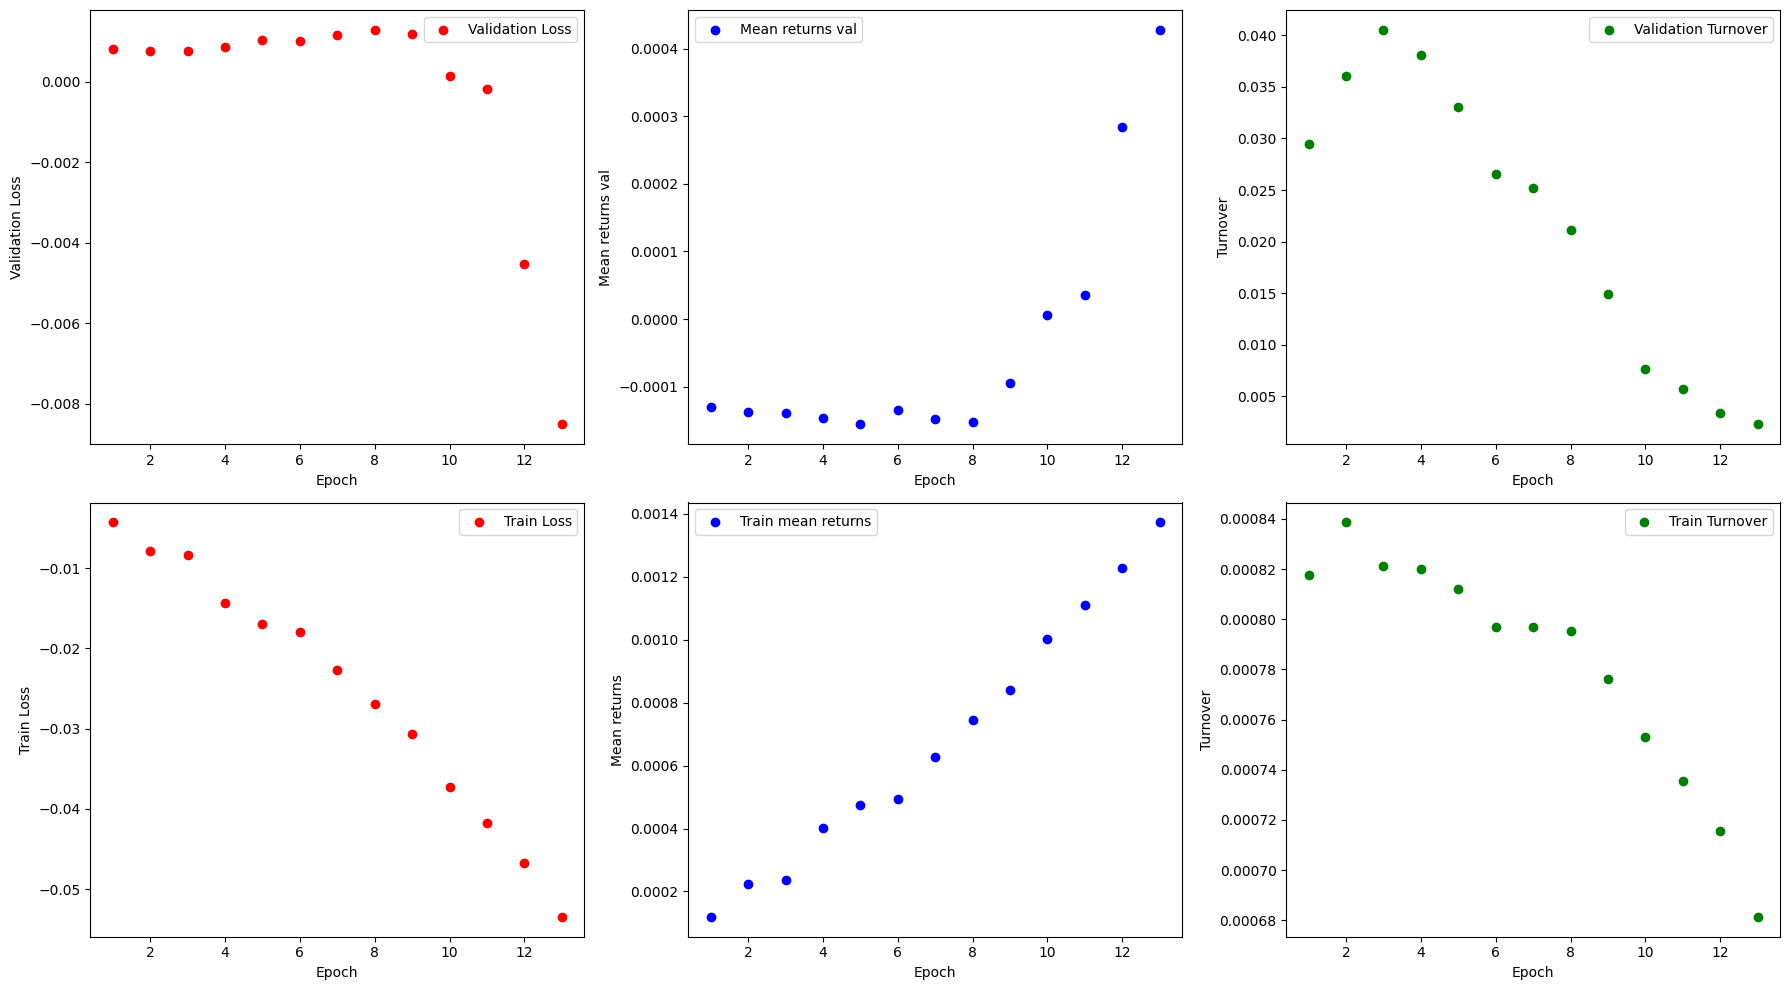

In [24]:
# Создаем 2 строки по 3 графика в каждой (валидация и тренировка)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 строки и 3 колонки

# Первая строка - Validation
# Первый график: Validation Loss
axes[0, 0].scatter(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), val_losses, label='Validation Loss', color='r')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].legend()

# Второй график: Validation Sharpe Ratio
axes[0, 1].scatter(range(PRINT_PARAM, len(val_sharpe_ratios) + 1, PRINT_PARAM), val_sharpe_ratios, label='Mean returns val', color='b')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Mean returns val')
axes[0, 1].legend()

# Третий график: Validation Turnover
axes[0, 2].scatter(range(PRINT_PARAM, len(val_turnovers) + 1, PRINT_PARAM), val_turnovers, label='Validation Turnover', color='g')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Turnover')
axes[0, 2].legend()

# Вторая строка - Train
# Первый график: Train Loss
axes[1, 0].scatter(range(PRINT_PARAM, len(train_losses) + 1, PRINT_PARAM), train_losses, label='Train Loss', color='r')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train Loss')
axes[1, 0].legend()

# Второй график: Train Sharpe Ratio
axes[1, 1].scatter(range(PRINT_PARAM, len(train_sharpe_ratios) + 1, PRINT_PARAM), train_sharpe_ratios, label='Train mean returns', color='b')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Mean returns')
axes[1, 1].legend()

# Третий график: Train Turnover
axes[1, 2].scatter(range(PRINT_PARAM, len(train_turnovers) + 1, PRINT_PARAM), train_turnovers, label='Train Turnover', color='g')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Turnover')
axes[1, 2].legend()

# Отображаем все графики
plt.tight_layout()  # Для корректного отображения всех графиков без наложения

plt.show()


-0.13657337307929993 0.7827612018585206


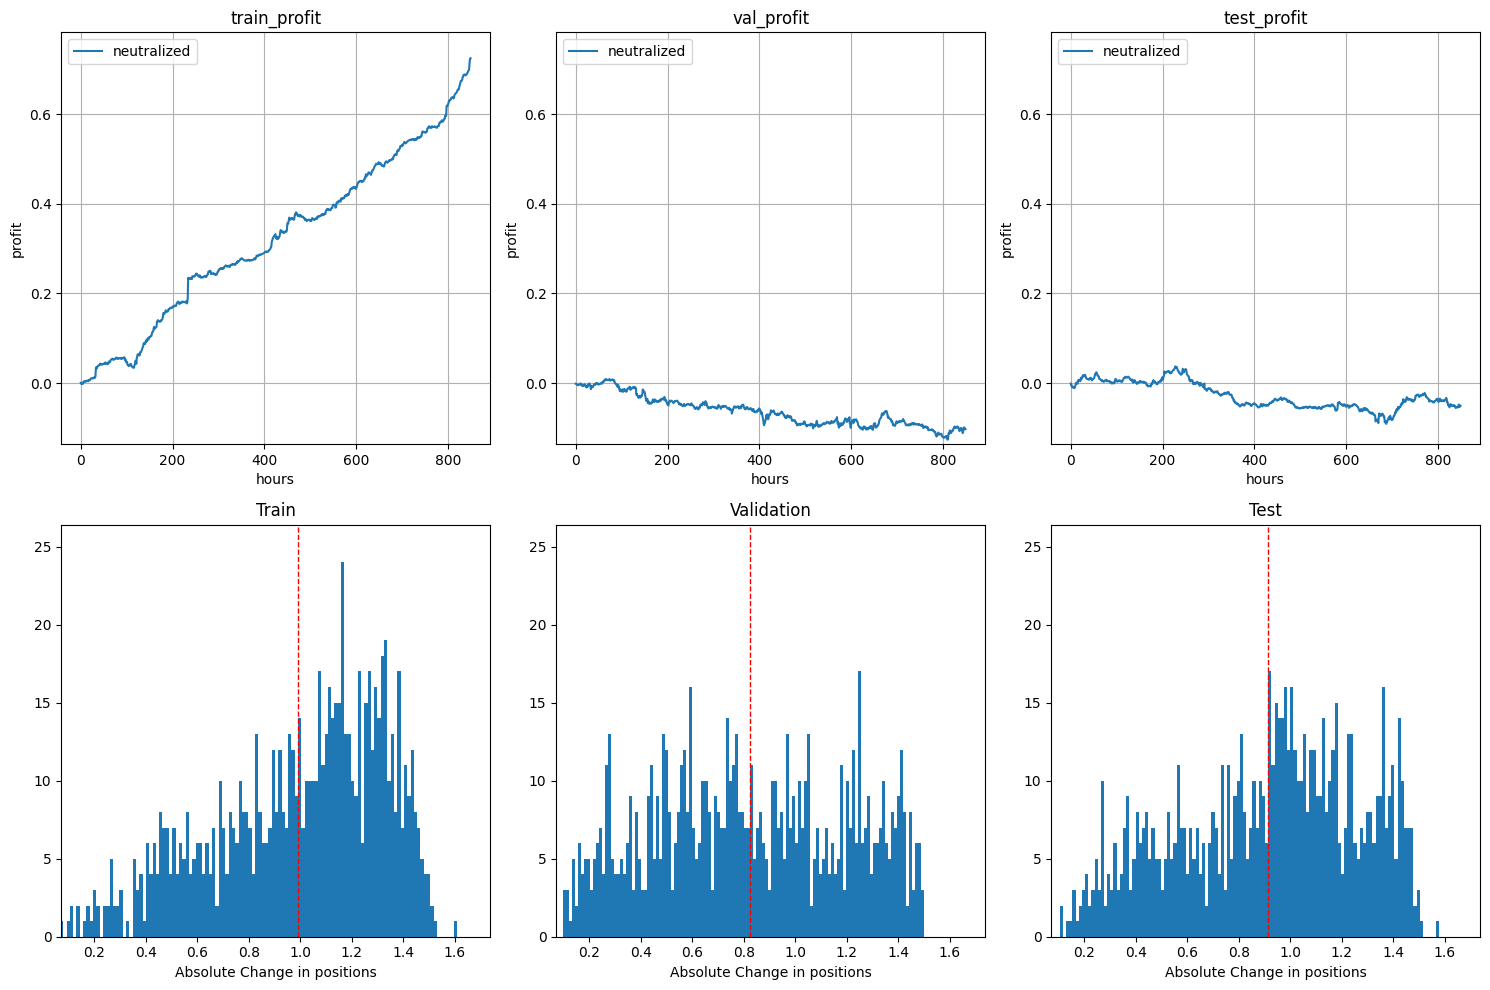

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

model.eval()
with torch.no_grad():
    train_predictions = model(x_train[-850:].to(device)).detach().cpu().numpy()

pred_dict['train'].append(train_predictions)

pred_df = pd.DataFrame(train_predictions, columns=close.columns)
alpha1 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha1 = alpha1.div(alpha1.abs().sum(axis=1), axis=0)
axes[0, 0].plot(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('train_profit')
axes[0, 0].set_xlabel('hours')
axes[0, 0].set_ylabel('profit')
axes[0, 0].grid(True)  # Добавление сетки

with torch.no_grad():
    val_predictions = model(x_val[-850:].to(device)).detach().cpu().numpy()

pred_dict['val'].append(val_predictions)

pred_df = pd.DataFrame(val_predictions, columns=close.columns)
alpha2 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha2 = alpha2.div(alpha2.abs().sum(axis=1), axis=0)
axes[0, 1].plot(
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('val_profit')
axes[0, 1].set_xlabel('hours')
axes[0, 1].set_ylabel('profit')
axes[0, 1].grid(True)  # Добавление сетки

with torch.no_grad():
    test_predictions = model(x_test.to(device)).detach().cpu().numpy()

pred_dict['test'].append(test_predictions)

pred_df = pd.DataFrame(test_predictions, columns=close.columns)
alpha3 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha3 = alpha3.div(alpha3.abs().sum(axis=1), axis=0)
axes[0, 2].plot(
    (alpha3.iloc[-len(x_test):] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 2].legend(loc='upper left')
axes[0, 2].set_title('test_profit')
axes[0, 2].set_xlabel('hours')
axes[0, 2].set_ylabel('profit')
axes[0, 2].grid(True)  # Добавление сетки

# Установим одинаковые пределы по оси y для всех графиков
min_value = min(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
    (alpha3.iloc[-850:] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
)
max_value = max(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max(),
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max(),
    (alpha3.iloc[-850:] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max()
)

min_value = min_value * 1.08 if min_value <= 0 else min_value - 0.03 * abs(max_value)
max_value = max_value * 1.08 if max_value >= 0 else max_value + 0.03 * abs(max_value)

print(min_value, max_value)

for i in range(3):
    axes[0, i].set_ylim(min_value, max_value)  # Одинаковые пределы по оси y для верхних графиков

# Рассчитаем минимальные и максимальные значения для оси x
x_min = min(alpha1.diff().abs().dropna().sum(axis=1).min(),
            alpha2.diff().abs().dropna().sum(axis=1).min(),
            alpha3.diff().abs().dropna().sum(axis=1).min())

x_max = max(alpha1.diff().abs().dropna().sum(axis=1).max(),
            alpha2.diff().abs().dropna().sum(axis=1).max(),
            alpha3.diff().abs().dropna().sum(axis=1).max())

x_min = x_min * 1.08
x_max = x_max * 1.08

# Построение гистограмм
hist_values1, bin_edges1 = np.histogram(alpha1.diff().abs().dropna().sum(axis=1), bins=120)
hist_values2, bin_edges2 = np.histogram(alpha2.diff().abs().dropna().sum(axis=1), bins=120)
hist_values3, bin_edges3 = np.histogram(alpha3.diff().abs().dropna().sum(axis=1), bins=120)

# Максимальное значение гистограммы
max_value = max([np.max(hist_values1), np.max(hist_values2), np.max(hist_values3)])

axes[1, 0].hist(alpha1.diff().abs().dropna().sum(axis=1), bins=120)
axes[1, 1].hist(alpha2.diff().abs().dropna().sum(axis=1), bins=120)
axes[1, 2].hist(alpha3.diff().abs().dropna().sum(axis=1), bins=120)

# Одинаковые пределы для оси y на гистограммах
for i in range(3):
    axes[1, i].set_ylim(0, max_value * 1.1)

# Установим одинаковые пределы по оси x для всех гистограмм
for ax in axes[1, :]:
    ax.set_xlim([x_min, x_max])

# Добавление вертикальных линий среднего
mean_alpha1 = (alpha1.diff().abs().dropna().sum(axis=1)).mean()
mean_alpha2 = (alpha2.diff().abs().dropna().sum(axis=1)).mean()
mean_alpha3 = (alpha3.diff().abs().dropna().sum(axis=1)).mean()

axes[1, 0].axvline(mean_alpha1, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha1:.2f}')
axes[1, 1].axvline(mean_alpha2, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha2:.2f}')
axes[1, 2].axvline(mean_alpha3, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha3:.2f}')

# Заголовки подграфиков
axes[1, 0].set_title('Train')
axes[1, 0].set_xlabel('Absolute Change in positions')

axes[1, 1].set_title('Validation')
axes[1, 1].set_xlabel('Absolute Change in positions')

axes[1, 2].set_title('Test')
axes[1, 2].set_xlabel('Absolute Change in positions')


# Сохраняем график
plt.tight_layout()
# fig.savefig(os.path.join(output_dir, 'results.png'))
plt.show()

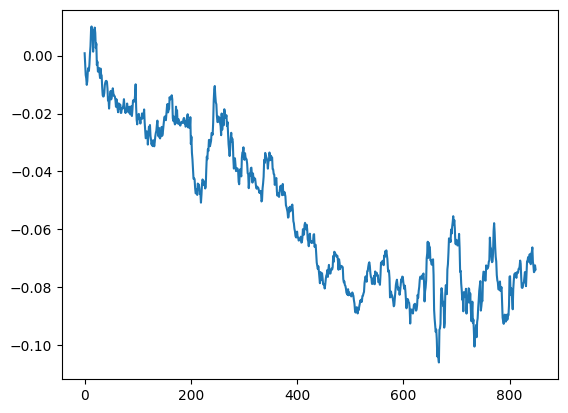

In [16]:
plt.plot(
    ((alpha3.iloc[-len(x_test):] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1) - 2 * 1e-4 * \
    (alpha3 - alpha3.shift()).abs().sum(axis=1)).cumsum(),
    label='neutralized'
)
plt.show()

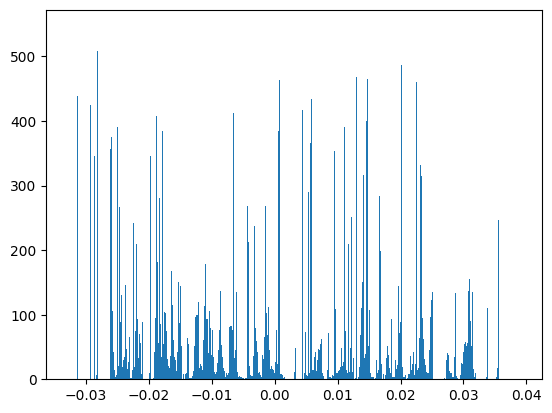

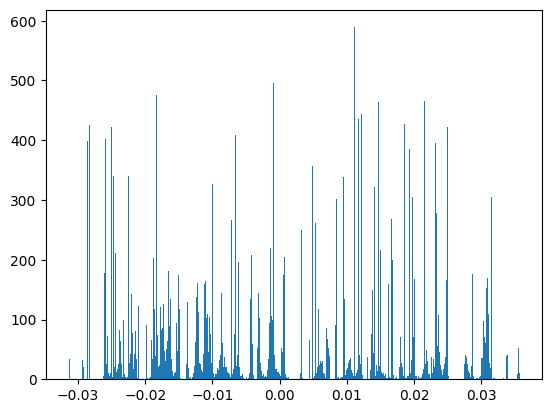

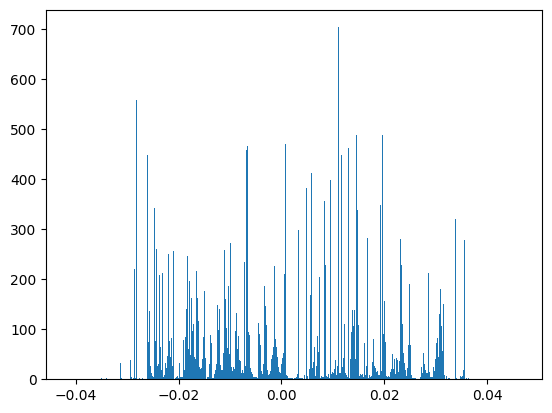

In [ ]:
_ = plt.hist(alpha1.values.flatten(), bins=1000)
plt.show()

_ = plt.hist(alpha2.values.flatten(), bins=1000)
plt.show()

_ = plt.hist(alpha3.values.flatten(), bins=1000)
plt.show()

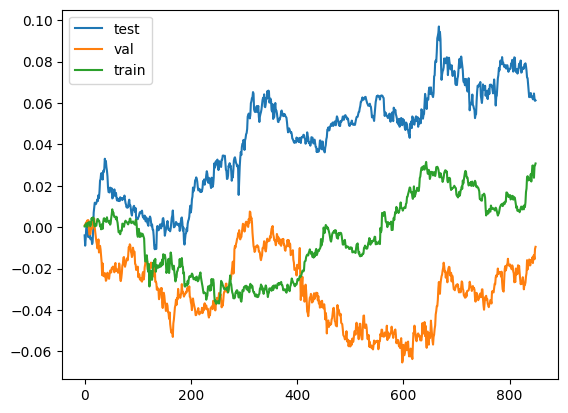

In [ ]:
alpha3 = alpha3.clip(-0.04, 0.04)
alpha3 = alpha3.subtract(alpha3.mean(axis=1), axis=0)
alpha3 = alpha3.div(alpha3.abs().sum(axis=1), axis=0)
# _ = plt.hist(alpha1.values.flatten(), bins=1000)

plt.plot(
    (alpha3.iloc[-850:] * pd.DataFrame(y_test[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='test'
)

alpha2 = alpha2.clip(-0.04, 0.04)
alpha2 = alpha2.subtract(alpha2.mean(axis=1), axis=0)
alpha2 = alpha2.div(alpha2.abs().sum(axis=1), axis=0)
# _ = plt.hist(alpha1.values.flatten(), bins=1000)

plt.plot(
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='val'
)

alpha1 = alpha1.clip(-0.04, 0.04)
alpha1 = alpha1.subtract(alpha1.mean(axis=1), axis=0)
alpha1 = alpha1.div(alpha1.abs().sum(axis=1), axis=0)
# _ = plt.hist(alpha1.values.flatten(), bins=1000)

plt.plot(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='train'
)

plt.legend()
plt.show()

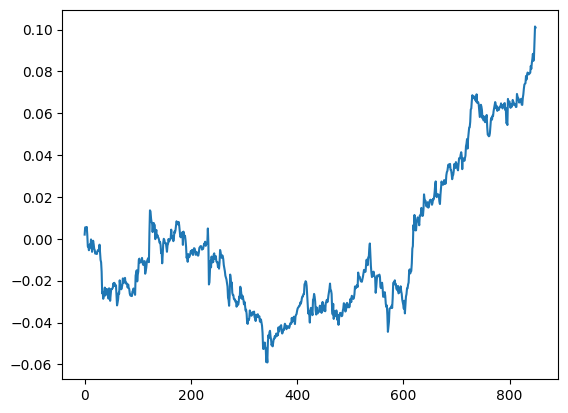

In [ ]:
plt.plot(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)

In [ ]:
# truncate (clip)

In [ ]:
print(alpha1.diff().abs().sum(axis=1).mean() * 6, alpha2.diff().abs().sum(axis=1).mean() * 6, alpha3.diff().abs().sum(axis=1).mean() * 6)
print(alpha1.diff().abs().sum(axis=1).mean(), alpha2.diff().abs().sum(axis=1).mean(), alpha3.diff().abs().sum(axis=1).mean())

2.3031983971595764 1.2352643609046936 1.63604736328125
0.3838664 0.2058774 0.27267456


In [ ]:
alpha1.isna().sum().mean(), alpha2.isna().sum().mean(), alpha3.isna().sum().mean()

(0.0, 0.0, 0.0)

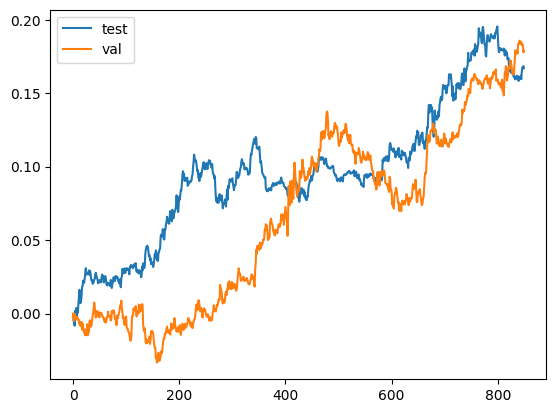

In [ ]:
(alpha3 * y_test.detach().numpy()).sum(axis=1).cumsum().plot(label='test')
(alpha2 * y_val[-850:].detach().numpy()).sum(axis=1).cumsum().plot(label='val')

plt.legend()
plt.show()

### Idea

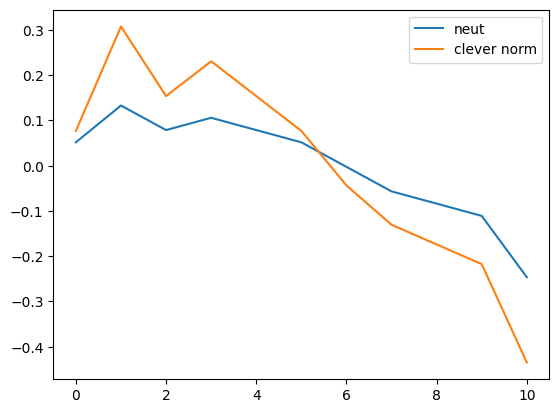

In [ ]:
a = np.array([1, 4, 2, 3, 2, 1, -1, -3, -4, -5, -10])

b = a - a.mean()
b = b / np.abs(b).sum()

c = np.concatenate((a[a > 0] / a[a > 0].sum(), a[a < 0] / np.abs(a[a < 0]).sum()))

plt.plot(b, label='neut')
plt.plot(c, label='clever norm')
plt.legend()

In [ ]:
# Подсчет параметров
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {num_params}")

Количество обучаемых параметров: 209087


In [ ]:
torch.save(model, 'models/binance/4hours/model15.pth')

In [ ]:
torch.save(model.state_dict(), "models/binance/hour/sixth.pth")

In [ ]:
share_values_np = np.array([tensor.cpu().detach().numpy() for tensor in share_values])
weights_penalties_np = np.array([tensor.cpu().detach().numpy() for tensor in weights_penalties])
turnover_penalties_np = np.array([tensor.cpu().detach().numpy() for tensor in turnover_penalties])
# weights_penalties
# turnover_penalties

In [ ]:
metrics = pd.DataFrame({
  'sharpe_values': share_values_np,
  # 'weights_penalties': weights_penalties_np,
  'turnover_penalties': turnover_penalties_np,
})

(metrics['turnover_penalties'] / metrics['sharpe_values']).abs().mean()

1898728.0

In [ ]:
(metrics['turnover_penalties'] / metrics['sharpe_values']).mean()

1261781.9

In [ ]:
metrics

,sharpe_values,turnover_penalties
0,-1.537370e-06,0.024755
1,3.795303e-07,0.024349
2,-7.884391e-07,0.024209
3,2.872403e-07,0.024441
4,-7.218107e-07,0.024204
...,...,...
597,-1.558490e-07,0.012689
598,9.118330e-07,0.013085
599,3.049328e-07,0.012781
600,-1.251286e-08,0.013381


In [ ]:
import json

In [ ]:
with open('models/binance/4hours/model12.json', 'w') as f:
    json.dumps(PARAMS_DICT, f)

TypeError: 'DataFrame' object is not callable

In [ ]:
PARAMS_DICT['device']

device(type='cuda')